In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import pdist
from collections import OrderedDict
from pandas.plotting import andrews_curves, parallel_coordinates
from IPython.display import HTML

In [3]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(14, 8))

### Load Data

In [5]:
data = pd.read_csv('wholesale_customers.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicatessen        440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
sales = data.drop(['Channel', 'Region'], axis=1)
sales_logged = np.log(sales)

In [7]:
outliers = LocalOutlierFactor()
sales_logged['inliers'] = outliers.fit_predict(sales_logged)
sales_logged_clean = sales_logged[sales_logged.inliers > 0].drop('inliers', axis=1)
sales_logged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 0 to 438
Data columns (total 6 columns):
Fresh               396 non-null float64
Milk                396 non-null float64
Grocery             396 non-null float64
Frozen              396 non-null float64
Detergents_Paper    396 non-null float64
Delicatessen        396 non-null float64
dtypes: float64(6)
memory usage: 21.7 KB


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [8]:
scaler = StandardScaler()
sales_logged_standardized = pd.DataFrame(scaler.fit_transform(sales_logged_clean), columns=sales.columns)

In [9]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(sales_logged_standardized)
sales_logged_standardized['cluster'] = kmeans.labels_

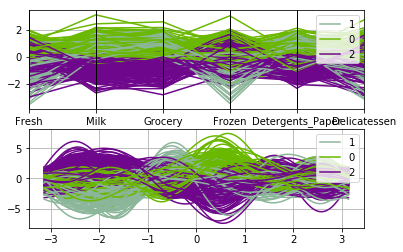

In [10]:
fig, axes = plt.subplots(2, 1)
parallel_coordinates(sales_logged_standardized, 'cluster', ax=axes[0]);
andrews_curves(sales_logged_standardized, 'cluster', ax=axes[1]);

In [11]:
cluster_data = sales_logged_standardized.drop('cluster', axis=1)
n = len(cluster_data)
Z = linkage(cluster_data, 'ward', optimal_ordering=True)
linkage_matrix = pd.DataFrame(data=Z, 
                              columns=['cluster_1', 'cluster_2', 'distance', 'n_objects'],
                              index=range(1, n))
for col in ['cluster_1', 'cluster_2', 'n_objects']:
    linkage_matrix[col] = linkage_matrix[col].astype(int)
linkage_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 1 to 395
Data columns (total 4 columns):
cluster_1    395 non-null int64
cluster_2    395 non-null int64
distance     395 non-null float64
n_objects    395 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.4 KB


In [12]:
c, coph_dists = cophenet(Z, pdist(sales_logged_standardized))
c

0.6270005251166351

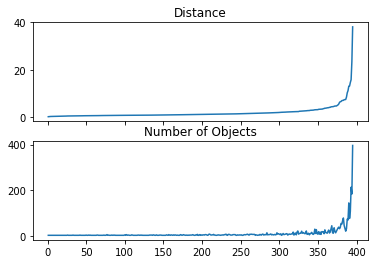

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True)
linkage_matrix.distance.plot(ax=axes[0], title='Distance')
linkage_matrix.n_objects.plot(ax=axes[1], title='Number of Objects');

### Get Cluster Numbers

In [14]:
n = len(Z)
clusters = OrderedDict()

for i, row in linkage_matrix.iterrows():
    cluster = []
    for c in row[['cluster_1', 'cluster_2']]:
        if c <= n:
            cluster.append(int(c))
        else:
            cluster += clusters[c]
    clusters[n+i] = cluster

In [15]:
scaler = StandardScaler()
pca = PCA().fit(sales_logged_standardized.drop('cluster', axis=1))
projected_df = cluster_data.dot(pca.components_[:2].T)

In [16]:
def get_points():
    points = projected_df.assign(n=1)
    return dict(enumerate(points.values.tolist()))

In [17]:
n_clusters = Z.shape[0]
points = get_points()
cluster_states = {0: get_points()}

for i, cluster in enumerate(Z[:, :2], 1):
    cluster_state = dict(cluster_states[i-1])
    try:
        merged_points = np.array([cluster_state.pop(c) for c in cluster])
    except:
        print(i, cluster, merged_points)
        break    
    cluster_size = merged_points[:, 2]

    new_point = np.average(merged_points[:, :2], axis=0, weights=cluster_size).tolist()

    new_point.append(cluster_size.sum())
    cluster_state[n_clusters+i] = new_point
    cluster_states[i] = cluster_state

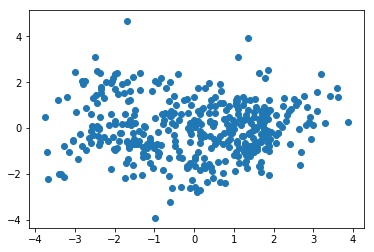

In [18]:
projection = projected_df.values
fig, ax = plt.subplots()
ax.scatter(*projection.T);

In [19]:
%%capture
fig, ax = plt.subplots()

xmin, ymin = np.min(projection, axis=0) * 1.1
xmax, ymax = np.max(projection, axis=0) * 1.1
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

In [20]:
scat = ax.scatter([], [])

def animate(i):
    data = pd.DataFrame(cluster_states[i]).values.T
    scat.set_offsets(data[:, :2])
    scat.set_sizes((data[:, 2] * 2) ** 2)
    return scat,
    
anim = FuncAnimation(
    fig, animate,frames=cluster_states.keys(), interval=250, blit=False)
HTML(anim.to_html5_video())

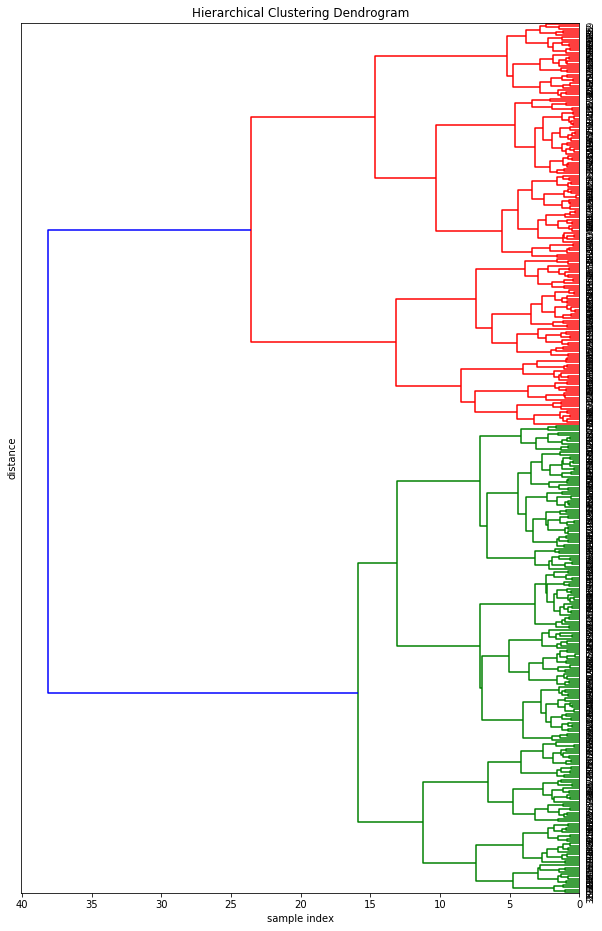

In [21]:
plt.figure(figsize=(10, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    orientation='left',
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
);